# VAE Debugging

### Investgating why the masking of sections causes KL Loss to drop dramatically

In [1]:
### Metrics working

import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

### DATA PREPARATION
gene_matrix_array = np.load("gene_matrix_list.npy")
rna_expression_df = pd.read_csv("rna_expression_list.csv")

# Check order of genes in both files is the same
assert gene_matrix_array.shape[0] == len(
    rna_expression_df
), "Mismatch in number of genes"

# Separate modification types
dnam_features = gene_matrix_array[:, :, 0]
h3k9me3_features = gene_matrix_array[:, :, 1]
h3k27me3_features = gene_matrix_array[:, :, 2]
rna_expression = (rna_expression_df["expression"].values > 0).astype(
    int
)  # convert expression to binary
expression_values = rna_expression.reshape(-1, 1)  # Shape (58780, 1)

# Concatenate all features, including expression, to make 1D
X = np.concatenate(
    (dnam_features, h3k9me3_features, h3k27me3_features, expression_values), axis=1
)


# Split into training, validation, and testing (70% training, 10% validation, 20% testing)
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [2]:
# section to be masked
mask_section = 0  # set to 0: DNAm, 1: K9, 2: K27, 3: expression

In [31]:
### Checking that the KL Divergence metric is the same as the custom KL Loss tracking


### Model definition
class FixedMaskingLayer(
    tf.keras.layers.Layer
):  # masks a single subset of the input data (passed into the VAE class)
    def __init__(self, mask_index, **kwargs):
        super(FixedMaskingLayer, self).__init__(**kwargs)
        self.mask_index = mask_index  # Fixed subset to mask

    def call(self, inputs, training=None):
        # Shape of the input
        batch_size = tf.shape(inputs)[0]

        # Create masks for each section: tf.concat() used to break input into masked and non-masked segments then concat them back together
        masks = [
            tf.concat(
                [
                    tf.fill([batch_size, 4000], -1.0),
                    tf.zeros([batch_size, 8001], dtype=tf.float32),
                ],
                axis=1,
            ),  # DNAm
            tf.concat(
                [
                    tf.zeros([batch_size, 4000], dtype=tf.float32),
                    tf.fill([batch_size, 4000], -1.0),
                    tf.zeros([batch_size, 4001], dtype=tf.float32),
                ],
                axis=1,
            ),  # K9
            tf.concat(
                [
                    tf.zeros([batch_size, 8000], dtype=tf.float32),
                    tf.fill([batch_size, 4000], -1.0),
                    tf.zeros([batch_size, 1], dtype=tf.float32),
                ],
                axis=1,
            ),  # K27
            tf.concat(
                [
                    tf.zeros([batch_size, 12000], dtype=tf.float32),
                    tf.fill([batch_size, 1], -1.0),
                ],
                axis=1,
            ),  # expression
        ]

        # Select the mask for the current batch
        mask = masks[self.mask_index]

        # Apply the mask to the input data
        masked_inputs = tf.where(mask != 0, mask, inputs)

        return masked_inputs, mask


class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # model
        self.encoder = encoder
        self.decoder = decoder
        # metrics
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.val_total_loss_tracker = tf.keras.metrics.Mean(name="val_loss")
        self.val_reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="val_recon_loss"
        )
        self.val_kl_loss_tracker = tf.keras.metrics.Mean(name="val_kl_loss")




    # access metrics like attributes
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,

            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker,

        ]

    def call(self, inputs):
        masked_inputs, mask = FixedMaskingLayer(mask_index=mask_section)(inputs)
        codings_mean, codings_log_var, codings = self.encoder(masked_inputs)
        reconstruction = self.decoder(codings)
        return codings_mean, codings_log_var, reconstruction, mask

    # override train step to track KL and recon loss separately
    def train_step(self, data):

        x, _ = data

        # using a gradient tape to track the operation for differentiation
        with tf.GradientTape() as tape:
            # pass input through model to get latent codings, reconstruction and random mask
            codings_mean, codings_log_var, reconstruction, mask = self(x)

            # get reconstruction loss for masked section
            reconstruction_loss = self.compute_reconstruction_loss(
                x, reconstruction, mask
            )
            # calc KL loss
            kl_loss = self.compute_kl_loss(codings_mean, codings_log_var, mask)
            # combine recon and KL loss for total loss
            total_loss = reconstruction_loss + kl_loss * 4

        # compute gradients of the total loss then update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # update metrics for current batch

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss) 

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # override test step to track KL and recon loss separately
    def test_step(self, data):
        x, _ = data
        codings_mean, codings_log_var, reconstruction, mask = self(x, training=False)
        reconstruction_loss = self.compute_reconstruction_loss(x, reconstruction, mask)
        kl_loss = self.compute_kl_loss(codings_mean, codings_log_var, mask)
        total_loss = reconstruction_loss + kl_loss * 4


        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.val_total_loss_tracker.result(),
            "recon_loss": self.val_reconstruction_loss_tracker.result(),
            "kl_loss": self.val_kl_loss_tracker.result(),

        }

    # calc recontruction loss for the masked input section
    def compute_reconstruction_loss(self, inputs, reconstructions, mask):
        mask_indices = tf.cast(mask == -1, tf.float32)
        reconstructions_clipped = tf.clip_by_value(reconstructions, 1e-7, 1 - 1e-7)
        # use .backend not .losses as there aren't automatic reductions
        loss = tf.keras.backend.binary_crossentropy(inputs, reconstructions_clipped)
        masked_loss = tf.reduce_sum(loss * mask_indices, axis=1) / tf.reduce_sum(
            mask_indices, axis=1
        )
        # avoid division by zero
        masked_loss = tf.where(
            tf.reduce_sum(mask_indices, axis=1) == 0, 0.0, masked_loss
        )

        return tf.reduce_mean(masked_loss)

    # calc KL Loss
    def compute_kl_loss(self, codings_mean, codings_log_var, mask):
        kl_loss = -0.5 * tf.reduce_sum(
            1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
            axis=-1,
        )
        # divide by masked section size so KL Loss and recon loss are on similar scales
        #mask_size = tf.reduce_sum(tf.cast(mask == -1, tf.float32))        
        return tf.reduce_mean(kl_loss) #/ tf.reduce_mean(mask_size)

    # reset metrics to avoid accumulation over batches
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()


# Define the encoder
codings_size = 300
inputs = tf.keras.layers.Input(shape=[12001])
masked_inputs, mask = FixedMaskingLayer(mask_index=mask_section)(inputs)
x = tf.keras.layers.Dense(512, activation="relu", kernel_initializer="he_normal")(
    masked_inputs
)
x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
codings_mean = tf.keras.layers.Dense(codings_size)(x)  # mean
codings_log_var = tf.keras.layers.Dense(codings_size)(x)  # log_var
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

# Define the decoder
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal")(
    decoder_inputs
)
x = tf.keras.layers.Dense(512, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(12001, activation="sigmoid")(x)  # Sigmoid for binary
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[x])


# Compile model
vae_model = VAE(encoder=variational_encoder, decoder=variational_decoder)
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)



In [32]:
# Train model
history = vae_model.fit(
    X_train,
    X_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],
    verbose=1,
)



Epoch 1/5
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 73s 48ms/step - kl_divergence: 8.8256 - kl_loss: 0.5483 - loss: 2.3879 - recon_loss: 0.1947 - val_kl_divergence: 0.0784 - val_kl_loss: 2.1135e-04 - val_loss: 0.1483 - val_recon_loss: 0.1474
Epoch 2/5
  95/1470 ━━━━━━━━━━━━━━━━━━━━ 1:04 47ms/step - kl_divergence: 0.0557 - kl_loss: 1.2101e-04 - loss: 0.1488 - recon_loss: 0.1484

KeyboardInterrupt: 

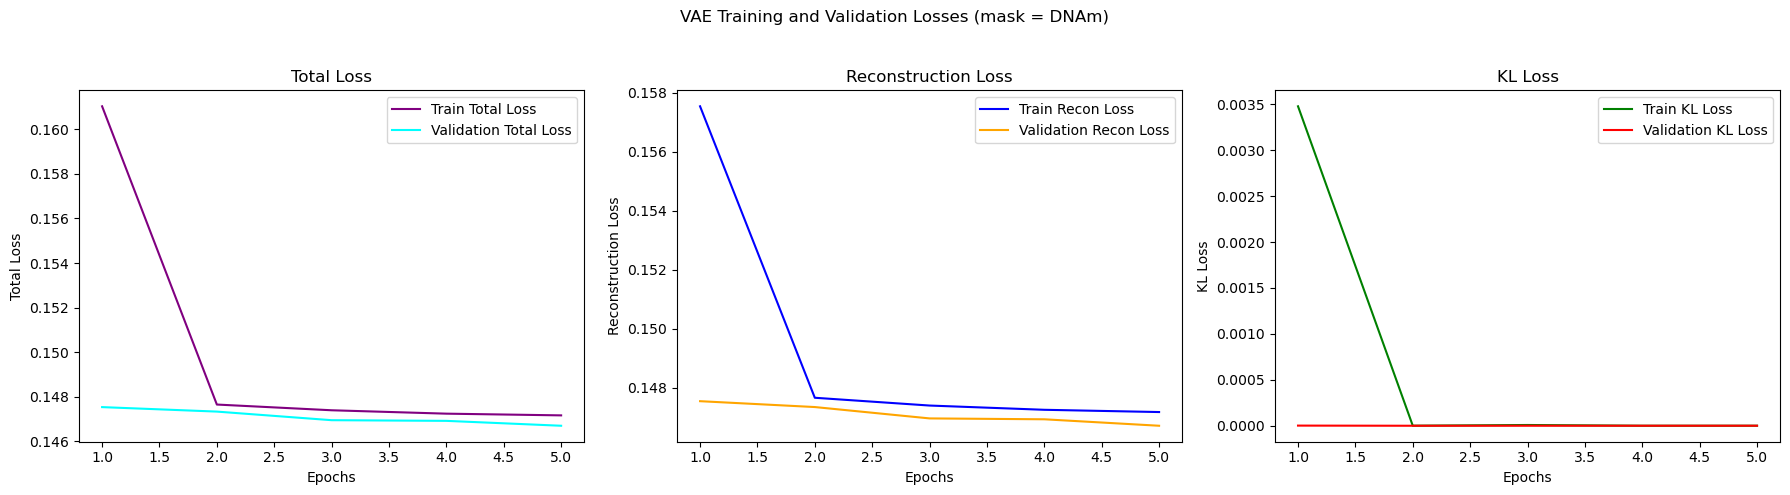

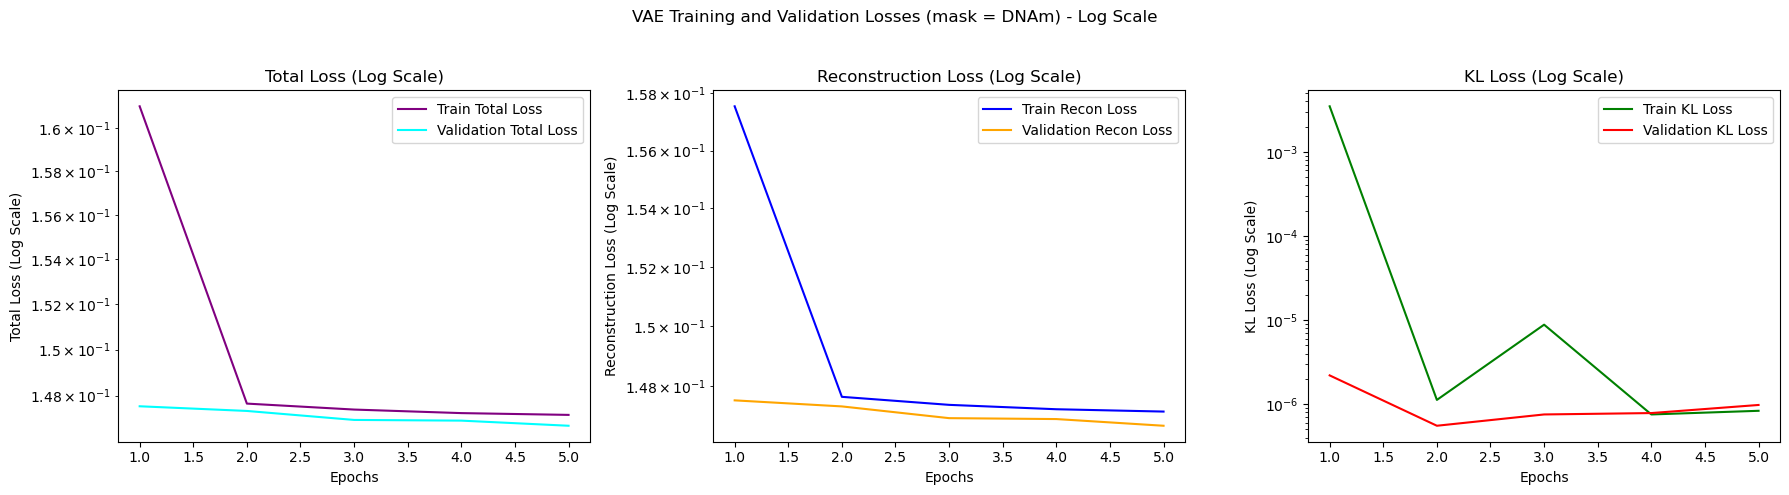

In [14]:
# Plot training and validation loss
# Create a figure with 2 subplots (1 row, 2 columns)
section_names = {0: "DNAm", 1: "K9", 2: "K27", 3: "expression"}
section_name = section_names[mask_section]

# get keys out of history.history
history_dict = history.history

# regular scale plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
epochs = range(1, len(history_dict["loss"]) + 1)


# plot for total loss
axs[0].plot(epochs, history_dict["loss"], label="Train Total Loss", color="purple")
axs[0].plot(
    epochs, history_dict["val_loss"], label="Validation Total Loss", color="cyan"
)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Total Loss")
axs[0].legend()
axs[0].set_title("Total Loss")

# Plot for reconstruction loss
axs[1].plot(epochs, history_dict["recon_loss"], label="Train Recon Loss", color="blue")
axs[1].plot(
    epochs,
    history_dict["val_recon_loss"],
    label="Validation Recon Loss",
    color="orange",
)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Reconstruction Loss")
axs[1].legend()
axs[1].set_title("Reconstruction Loss")

# Plot for KL loss
axs[2].plot(epochs, history_dict["kl_loss"], label="Train KL Loss", color="green")
axs[2].plot(
    epochs, history_dict["val_kl_loss"], label="Validation KL Loss", color="red"
)
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("KL Loss")
axs[2].legend()
axs[2].set_title("KL Loss")

plt.suptitle("VAE Training and Validation Losses (mask = {})".format(section_name))
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("vae_loss_plot_{}_300_v4.png".format(section_name))

# Log scale plot
fig_log, axs_log = plt.subplots(1, 3, figsize=(18, 5))

# Plot for total loss (log scale)
axs_log[0].plot(epochs, history_dict["loss"], label="Train Total Loss", color="purple")
axs_log[0].plot(
    epochs, history_dict["val_loss"], label="Validation Total Loss", color="cyan"
)
axs_log[0].set_xlabel("Epochs")
axs_log[0].set_ylabel("Total Loss (Log Scale)")
axs_log[0].set_yscale("log")
axs_log[0].legend()
axs_log[0].set_title("Total Loss (Log Scale)")

# Plot for reconstruction loss (log scale)
axs_log[1].plot(
    epochs, history_dict["recon_loss"], label="Train Recon Loss", color="blue"
)
axs_log[1].plot(
    epochs,
    history_dict["val_recon_loss"],
    label="Validation Recon Loss",
    color="orange",
)
axs_log[1].set_xlabel("Epochs")
axs_log[1].set_ylabel("Reconstruction Loss (Log Scale)")
axs_log[1].set_yscale("log")
axs_log[1].legend()
axs_log[1].set_title("Reconstruction Loss (Log Scale)")

# Plot for KL loss (log scale)
axs_log[2].plot(epochs, history_dict["kl_loss"], label="Train KL Loss", color="green")
axs_log[2].plot(
    epochs, history_dict["val_kl_loss"], label="Validation KL Loss", color="red"
)
axs_log[2].set_xlabel("Epochs")
axs_log[2].set_ylabel("KL Loss (Log Scale)")
axs_log[2].set_yscale("log")
axs_log[2].legend()
axs_log[2].set_title("KL Loss (Log Scale)")

plt.suptitle(
    "VAE Training and Validation Losses (mask = {}) - Log Scale".format(section_name)
)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("vae_loss_plot_{}_300_v4_log.png".format(section_name))

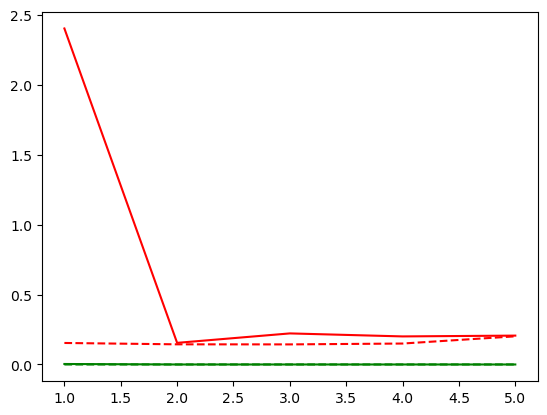

In [15]:
### PLOTTING BUILT IN KL AND CUSTOM KL
# custom
plt.plot(epochs, history_dict["kl_loss"], label="Train KL Loss (custom)", color="green")
plt.plot(epochs, history_dict["val_kl_loss"], '--', label="Validation KL Loss", color="green")

# built in
plt.plot(epochs, history_dict["kl_divergence"], label="Train KL Divergence (built-in)", color="red")
plt.plot(epochs, history_dict["val_kl_divergence"], '--', label="Validation KL Divergence", color="red")
